In [416]:
from matplotlib import pyplot as plt
from ssa import SSA

import yfinance
import numpy


# Select a window of 90 days 
timeseries = numpy.log1p(yfinance.download('WU', period='1Y', window=90)['Adj Close'].pct_change())
timeseries.dropna(inplace=True)
s = SSA(timeseries[:-7])

[*********************100%***********************]  1 of 1 completed


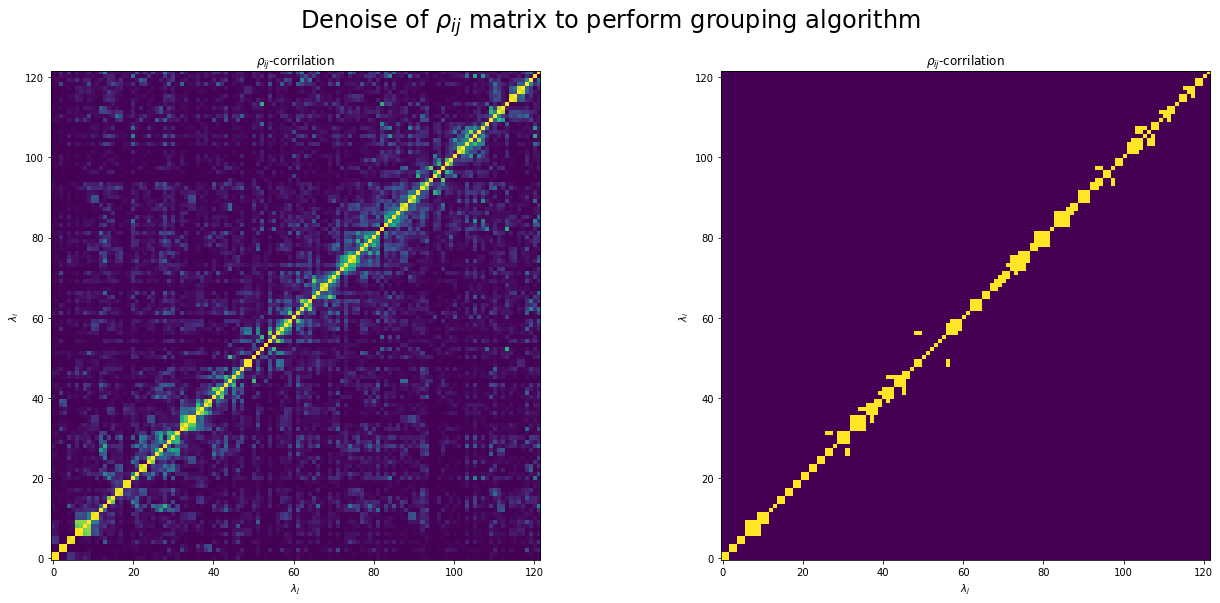

In [417]:
# Look at the w-corr matrix and its filtered version
fig, ax = plt.subplots(ncols=2, figsize=(22, 9))
ax[0].imshow(s.get_wcorr(), origin='lower')
ax[0].set_title('$\\rho_{ij}$-corrilation')
ax[0].set_ylabel('$\lambda_{i}$')
ax[0].set_xlabel('$\lambda_{j}$')

ax[1].imshow(s.get_wcorr_grouping(), origin='lower')
ax[1].set_title('$\\rho_{ij}$-corrilation')
ax[1].set_ylabel('$\lambda_{i}$')
ax[1].set_xlabel('$\lambda_{j}$')

fig.suptitle('Denoise of $\\rho_{ij}$ matrix to perform grouping algorithm', fontsize=24)
plt.show()

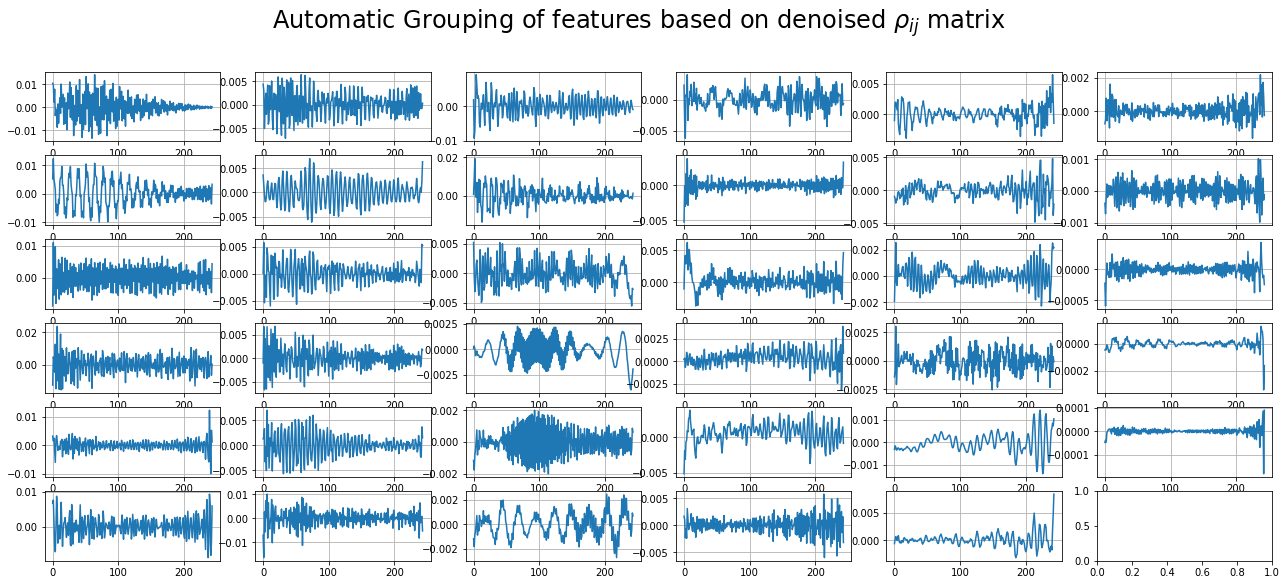

In [418]:
# Reconstruction of identified groups
groups = s.get_grouping()
xy = int(numpy.sqrt(len(groups)))
fig, ax = plt.subplots(nrows=xy+1, ncols=xy+1, figsize=(22, 9))

row = 0
col = 0
for group in groups:
    ax[row][col].plot(s.get_reconstructed(group[0],group[-1]))
    ax[row][col].grid(True)
    row = row + 1
    # col = (col + 1) % 5
    if row % (xy+1) == 0:
        row = 0
        col += 1
        col = col % (xy+1)

fig.suptitle('Automatic Grouping of features based on denoised $\\rho_{ij}$ matrix', fontsize=24)
plt.show()

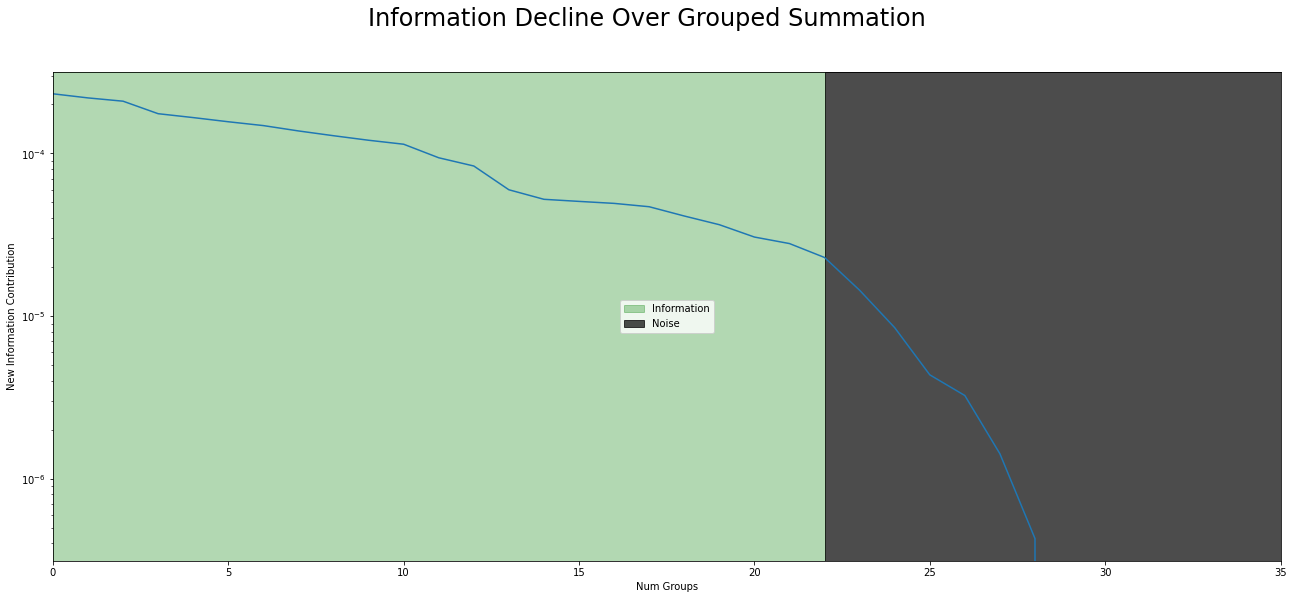

In [419]:
# View the decline of information as new features are added
timeseries_variance = numpy.var(timeseries)

groups = s.get_grouping()
var_decline = []
for groupidx in range(len(groups)):
    var_decline.append(numpy.var(timeseries) - numpy.var(s.get_reconstructed(groups[0][0], groups[groupidx][-1])))

# We use a cutoff of 99% for information cutoff between noise and not.
# Another way to think of this is that we want to include ~99% of the information extracted
# from teh SSA, leaving the last 1% to be considered market noise.
cutoff = numpy.sum(var_decline) * 0.99
cutoffidx = (numpy.where(numpy.array(var_decline).cumsum() > cutoff)[0][0])

fig, ax = plt.subplots(figsize=(22, 9))
ax.plot(var_decline)
ax.set_xlabel('Num Groups')
ax.set_ylabel('New Information Contribution')
ax.set_yscale('log')
ax.axvspan(0, cutoffidx, color='green', label='Information', alpha=0.3)
ax.axvspan(cutoffidx, len(groups), color='black', label='Noise', alpha=0.7)

fig.suptitle('Information Decline Over Grouped Summation', fontsize=24)
plt.legend(loc='center')
plt.xlim(0, len(groups))
plt.show()

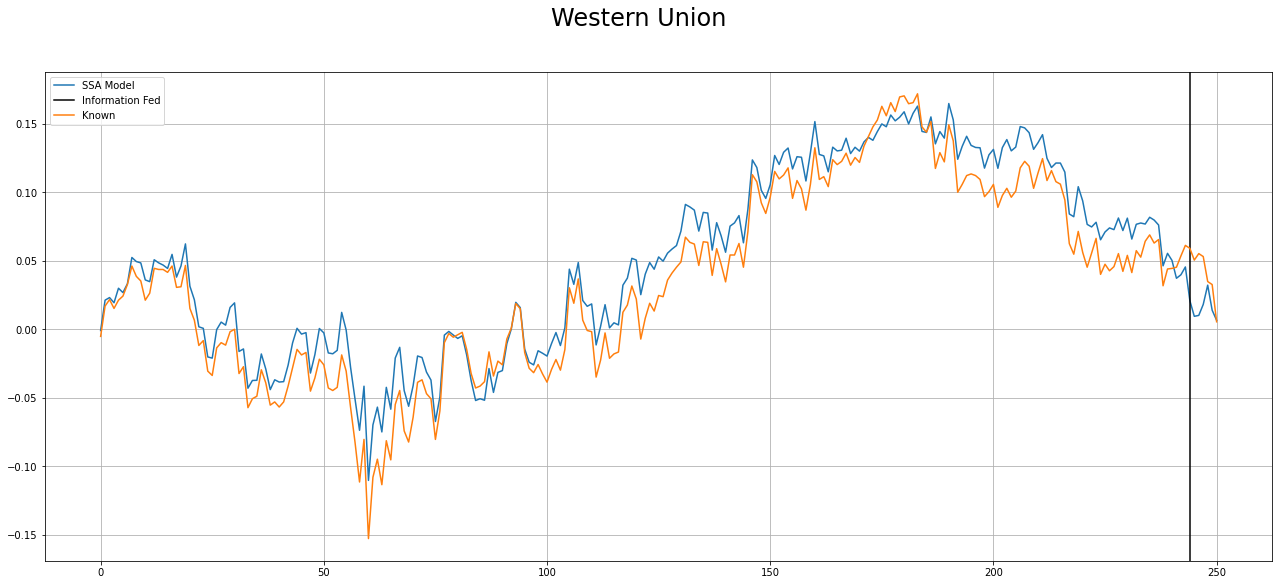

In [436]:
forecast = s.forecast(groups[0][0], groups[cutoffidx][-1], forecast=7)
information_variance = numpy.where(numpy.array(var_decline).cumsum() > cutoff)
information_variance = numpy.array(var_decline).cumsum()[information_variance][0]

fig, ax = plt.subplots(figsize=(22, 9))
ax.plot(numpy.array(forecast.T[0,:])[0].cumsum(), label='SSA Model')
ax.axvline(len(timeseries)-7, color='black', label='Information Fed')
ax.plot(numpy.array(timeseries.to_list()).cumsum(), label='Known')
fig.suptitle('Western Union', fontsize=24)
plt.legend()
plt.grid()
plt.show()